In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels as stats
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [37]:
train_df = pd.read_csv('dengue_train_engineered.csv')
test_df = pd.read_csv('dengue_test_engineered.csv')

In [38]:
train_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,optimal_temp,optimal_humidity,optimal_breeding,ndvi_avg,reanalysis_air_temp_k_anomaly,reanalysis_relative_humidity_percent_anomaly,precipitation_amt_mm_anomaly,reanalysis_specific_humidity_g_per_kg_anomaly,precipitation_amt_mm_log,station_precip_mm_log
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,-1.275676,...,0,0,0,0.150606,-0.952615,-1.420812,-21.706000,-1.282393,2.596746,2.833213
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,-0.732817,...,0,0,0,0.157479,-0.481570,-0.199542,-1.742667,-0.423144,3.170526,2.261763
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,-0.248251,...,0,0,0,0.133315,-0.025989,0.697426,0.603333,0.308602,3.570659,3.747148
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,-0.073370,...,0,0,0,0.209286,-0.230260,-0.075571,-39.867333,-0.226653,2.794839,1.609438
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,0.378405,...,0,0,0,0.239235,0.110515,-0.183972,-58.974000,-0.025925,2.142416,1.916923


# Running XGBRegressor as Baseline model

1. Define the model's training function
2. Train models for each city
3. Check performance metrics for each of the models
4. Visualize feature importance and other visuals
5. Begin feature selection process, and revisit feature engineering
6. Run models again

In [39]:
def train_evaluate_model(city_name):
    city_train = train_df[train_df['city'] == city_name].copy()

    exclude_cols = ['city', 'week_start_date', 'total_cases']
    feature_cols = [col for col in city_train.columns if col not in exclude_cols]

    X = city_train[feature_cols]
    y = city_train['total_cases']

    tscv = TimeSeriesSplit(n_splits=5)  #<--- doing a time series split for cross-validation

    cv_scores_rmse = []
    cv_scores_mae = []

    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
    )
    
    last_X_test = None
    last_y_test = None
    last_y_pred = None

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  verbose=False)

        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        cv_scores_rmse.append(rmse)
        cv_scores_mae.append(mae)
        
        last_X_test = X_test
        last_y_test = y_test
        last_y_pred = y_pred

    final_model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
    )

    final_model.fit(X, y)

    importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    return {
        'model': final_model,
        'cv_rmse': np.mean(cv_scores_rmse),
        'cv_mae': np.mean(cv_scores_mae),
        'importance': importance.head(20),
        'last_X_test': last_X_test,
        'last_y_test': last_y_test,
        'last_y_pred': last_y_pred
    }

In [40]:
# train models for each city
sj_results = train_evaluate_model('sj')
iq_results = train_evaluate_model('iq')

In [41]:
print(f"San Juan model: CV MAE = {sj_results['cv_mae']:.2f}")
print(f"Iquitos model: CV MAE = {iq_results['cv_mae']:.2f}")

San Juan model: CV MAE = 13.21
Iquitos model: CV MAE = 5.80


In [42]:
def evaluate_on_test_set(city_name):
    """Evaluate the trained model on the pre-engineered test set"""
    
    # Get training data for this city
    city_train = train_df[train_df['city'] == city_name].copy()
    
    # Define features
    exclude_cols = ['city', 'week_start_date', 'total_cases']
    feature_cols = [col for col in city_train.columns if col not in exclude_cols]
    
    # Train model on all training data
    X = city_train[feature_cols]
    y = city_train['total_cases']
    
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42
    )
    
    model.fit(X, y)
    
    # Now evaluate on test data
    city_test = test_df[test_df['city'] == city_name].copy()
    X_test = city_test[feature_cols]
    y_test = city_test['total_cases']
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    
    return {
        'model': model,
        'test_mae': mae,
        'y_test': y_test,
        'y_pred': y_pred
    }

# Try it
sj_test_results = evaluate_on_test_set('sj')
iq_test_results = evaluate_on_test_set('iq')

print(f"San Juan test MAE: {sj_test_results['test_mae']:.2f}")
print(f"Iquitos test MAE: {iq_test_results['test_mae']:.2f}")

San Juan test MAE: 7.21
Iquitos test MAE: 4.90


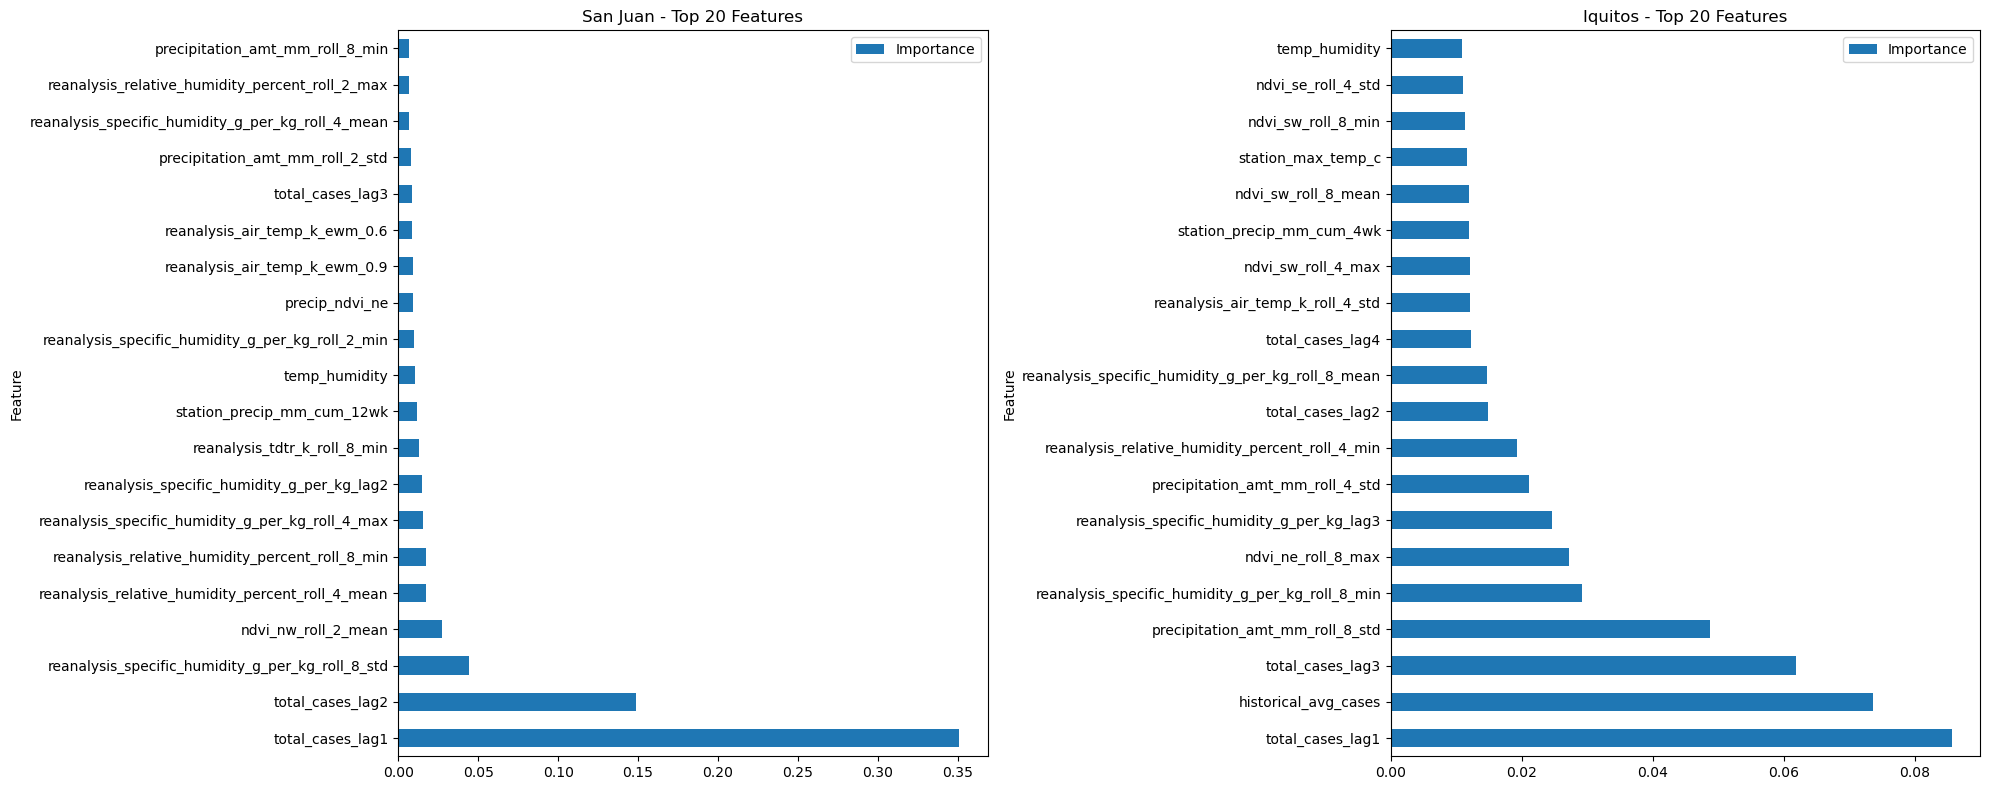

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sj_importance = sj_results['importance']
sj_importance.head(20).plot.barh(x='Feature', y='Importance', ax=ax1)
ax1.set_title('San Juan - Top 20 Features')

iq_importance = iq_results['importance']
iq_importance.head(20).plot.barh(x='Feature', y='Importance', ax=ax2)
ax2.set_title('Iquitos - Top 20 Features')

plt.tight_layout()
plt.show()

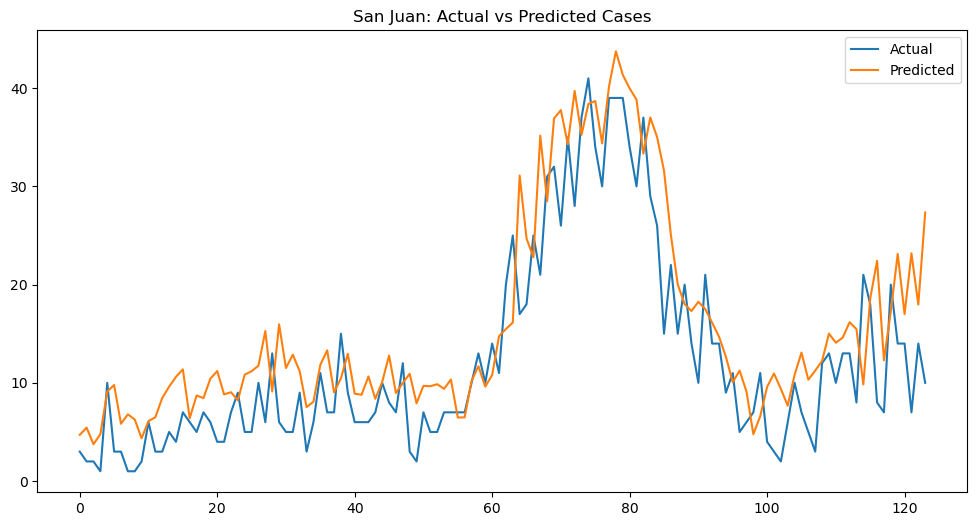

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(sj_results['last_y_test'].values, label='Actual')
plt.plot(sj_results['last_y_pred'], label='Predicted')
plt.title('San Juan: Actual vs Predicted Cases')
plt.legend()
plt.show()

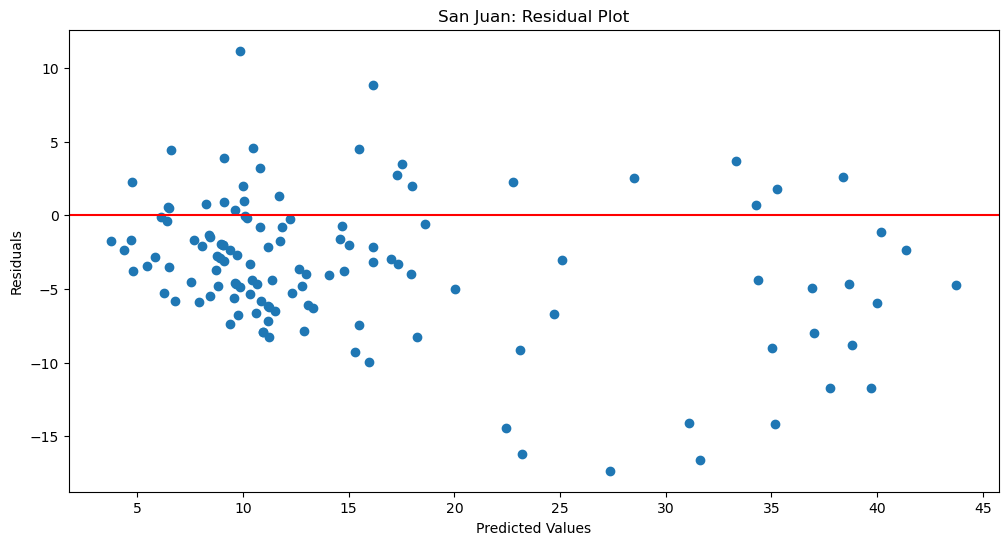

In [45]:
residuals = sj_results['last_y_test'] - sj_results['last_y_pred']
plt.figure(figsize=(12, 6))
plt.scatter(sj_results['last_y_pred'], residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('San Juan: Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

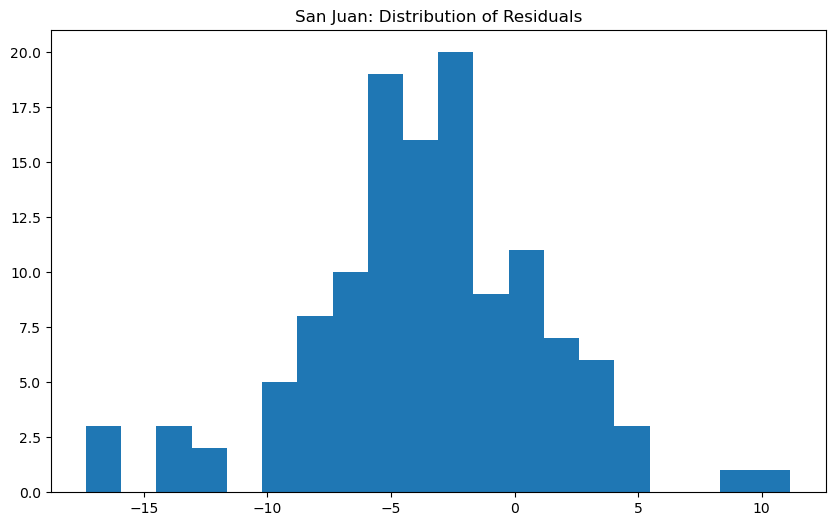

In [46]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20)
plt.title('San Juan: Distribution of Residuals')
plt.show()

In [47]:
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat}")
# Values close to 2 indicate no autocorrelation
# Values toward 0 indicate positive autocorrelation
# Values toward 4 indicate negative autocorrelation

Durbin-Watson statistic: 1.3819000931504621


In [48]:
sj_results = train_evaluate_model('sj')
sj_importance = sj_results['importance']

sj_importance['Cumulative'] = sj_importance['Importance'].cumsum()
print(sj_importance.head(50))

                                               Feature  Importance  Cumulative
22                                    total_cases_lag1    0.351125    0.351125
23                                    total_cases_lag2    0.148744    0.499870
81    reanalysis_specific_humidity_g_per_kg_roll_8_std    0.044435    0.544305
118                                ndvi_nw_roll_2_mean    0.027500    0.571806
62    reanalysis_relative_humidity_percent_roll_4_mean    0.017509    0.589315
68     reanalysis_relative_humidity_percent_roll_8_min    0.017084    0.606399
75    reanalysis_specific_humidity_g_per_kg_roll_4_max    0.015611    0.622010
35          reanalysis_specific_humidity_g_per_kg_lag2    0.015037    0.637047
104                       reanalysis_tdtr_k_roll_8_min    0.012893    0.649940
162                         station_precip_mm_cum_12wk    0.011684    0.661624
184                                      temp_humidity    0.010376    0.672001
72    reanalysis_specific_humidity_g_per_kg_roll_2_m

In [49]:
# Modify this to work with your existing code structure
def analyze_feature_categories(city_name):
    # Create a temporary copy of the city data
    temp_city_train = train_df[train_df['city'] == city_name].copy()
    
    # Get feature columns
    exclude_cols = ['city', 'week_start_date', 'total_cases']
    temp_feature_cols = [col for col in temp_city_train.columns if col not in exclude_cols]
    
    # Get importance DataFrame
    if city_name == 'sj':
        importance_df = sj_importance
    else:
        importance_df = iq_importance
    
    # Define feature categories
    lag_features = [col for col in temp_feature_cols if 'lag' in col]
    seasonal_features = ['weekofyear_sin', 'weekofyear_cos', 'month_sin', 'month_cos', 
                       'rainy_season', 'peak_season', 'historical_avg_cases']
    humidity_features = [col for col in temp_feature_cols if 'humidity' in col]
    temp_features = [col for col in temp_feature_cols if 'temp' in col]
    ndvi_features = [col for col in temp_feature_cols if 'ndvi' in col]
    precip_features = [col for col in temp_feature_cols if 'precip' in col or 'precipitation' in col]
    interaction_features = [col for col in temp_feature_cols if '_' in col and 
                          not any(x in col for x in ['roll', 'lag', 'cum'])]
    
    # Check importance by category
    results = {}
    for category_name, category_features in [
        ('Lag', lag_features),
        ('Seasonal', seasonal_features),
        ('Humidity', humidity_features),
        ('Temperature', temp_features),
        ('NDVI', ndvi_features),
        ('Precipitation', precip_features),
        ('Interactions', interaction_features)
    ]:
        # Filter importance for this category
        cat_importance = importance_df[importance_df['Feature'].isin(category_features)]
        total_importance = cat_importance['Importance'].sum()
        
        print(f"\n{category_name} Features - Total Importance: {total_importance:.4f}")
        print(cat_importance.head(5))  # Top 5 features in this category
        
        results[category_name] = {
            'total_importance': total_importance,
            'top_features': cat_importance.head(5)
        }
    
    return results

# Run the analysis for San Juan
sj_category_analysis = analyze_feature_categories('sj')


Lag Features - Total Importance: 0.5234
                                       Feature  Importance  Cumulative
22                            total_cases_lag1    0.351125    0.351125
23                            total_cases_lag2    0.148744    0.499870
35  reanalysis_specific_humidity_g_per_kg_lag2    0.015037    0.637047
24                            total_cases_lag3    0.008509    0.716886

Seasonal Features - Total Importance: 0.0000
Empty DataFrame
Columns: [Feature, Importance, Cumulative]
Index: []

Humidity Features - Total Importance: 0.1426
                                             Feature  Importance  Cumulative
81  reanalysis_specific_humidity_g_per_kg_roll_8_std    0.044435    0.544305
62  reanalysis_relative_humidity_percent_roll_4_mean    0.017509    0.589315
68   reanalysis_relative_humidity_percent_roll_8_min    0.017084    0.606399
75  reanalysis_specific_humidity_g_per_kg_roll_4_max    0.015611    0.622010
35        reanalysis_specific_humidity_g_per_kg_lag2    0.

In [50]:
def enhance_sj_model(train_df, test_df):
    train_enhanced = train_df.copy()
    test_enhanced = test_df.copy()
    
    sj_train = train_enhanced[train_enhanced['city'] == 'sj']
    sj_test = test_enhanced[test_enhanced['city'] == 'sj']
    
    # Adding an acceleration feature
    sj_train['cases_acceleration'] = sj_train['total_cases'].diff().diff()
    sj_test['cases_acceleration'] = sj_test['total_cases'].diff().diff()
    
    # Adding another lag interaction
    sj_train['lag1_lag2'] = sj_train['total_cases_lag1'] * sj_train['total_cases_lag2']
    sj_test['lag1_lag2'] = sj_test['total_cases_lag1'] * sj_test['total_cases_lag2']
    
    # Adding a humidity threshold feature
    humidity_threshold = sj_train['reanalysis_specific_humidity_g_per_kg'].quantile(0.8)
    sj_train['high_humidity'] = (sj_train['reanalysis_specific_humidity_g_per_kg'] > humidity_threshold).astype(int)
    sj_test['high_humidity'] = (sj_test['reanalysis_specific_humidity_g_per_kg'] > humidity_threshold).astype(int)
    
    # Replacing in the original dfs
    train_enhanced.loc[train_enhanced['city'] == 'sj'] = sj_train
    test_enhanced.loc[test_enhanced['city'] == 'sj'] = sj_test
    
    # Fill NAs with 0
    train_enhanced = train_enhanced.fillna(0)
    test_enhanced = test_enhanced.fillna(0)
    
    return train_enhanced, test_enhanced

In [51]:
train_enhanced, test_enhanced = enhance_sj_model(train_df, test_df)

def evaluate_on_enhanced_test(city_name, train_enhanced, test_enhanced):
    """Evaluate the trained model on the enhanced test set"""
    
    city_train = train_enhanced[train_enhanced['city'] == city_name].copy()
    
    exclude_cols = ['city', 'week_start_date', 'total_cases']
    feature_cols = [col for col in city_train.columns if col not in exclude_cols]
    
    X = city_train[feature_cols]
    y = city_train['total_cases']
    
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42
    )
    
    model.fit(X, y)
    
    city_test = test_enhanced[test_enhanced['city'] == city_name].copy()
    X_test = city_test[feature_cols]
    y_test = city_test['total_cases']
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    
    return {
        'model': model,
        'test_mae': mae,
        'y_test': y_test,
        'y_pred': y_pred
    }

sj_enhanced_results = evaluate_on_enhanced_test('sj', train_enhanced, test_enhanced)
print(f"Enhanced San Juan test MAE: {sj_enhanced_results['test_mae']:.2f}")

/var/folders/m7/tzk7gpbd05j79z_hsb25z6jm0000gn/T/ipykernel_47016/3257644594.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sj_train['cases_acceleration'] = sj_train['total_cases'].diff().diff()
/var/folders/m7/tzk7gpbd05j79z_hsb25z6jm0000gn/T/ipykernel_47016/3257644594.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sj_test['cases_acceleration'] = sj_test['total_cases'].diff().diff()
/var/folders/m7/tzk7gpbd05j79z_hsb25z6jm0000gn/T/ipykernel_47016/3257644594.py:13: SettingWithCopyWarning: 
A value

Enhanced San Juan test MAE: 7.21


In [52]:
def evaluate_combined_model(train_df, test_df):
    """Evaluate a single model trained on both cities combined"""
    
    # Define features
    exclude_cols = ['city', 'week_start_date', 'total_cases']
    feature_cols = [col for col in train_df.columns if col not in exclude_cols]
    
    train_df_encoded = pd.get_dummies(train_df, columns=['city'], drop_first=False)
    test_df_encoded = pd.get_dummies(test_df, columns=['city'], drop_first=False)
    
    feature_cols = [col for col in train_df_encoded.columns 
                  if col not in ['week_start_date', 'total_cases']]
    
    X = train_df_encoded[feature_cols]
    y = train_df_encoded['total_cases']
    
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42
    )
    
    model.fit(X, y)
    
    X_test = test_df_encoded[feature_cols]
    y_test = test_df_encoded['total_cases']
    
    y_pred = model.predict(X_test)
    
    overall_mae = mean_absolute_error(y_test, y_pred)
    
    sj_mask = test_df_encoded['city_sj'] == 1
    iq_mask = test_df_encoded['city_iq'] == 1
    
    sj_mae = mean_absolute_error(y_test[sj_mask], y_pred[sj_mask])
    iq_mae = mean_absolute_error(y_test[iq_mask], y_pred[iq_mask])
    
    return {
        'model': model,
        'overall_mae': overall_mae,
        'sj_mae': sj_mae,
        'iq_mae': iq_mae,
        'y_test': y_test,
        'y_pred': y_pred
    }

combined_results = evaluate_combined_model(train_df, test_df)

print(f"Combined model - Overall test MAE: {combined_results['overall_mae']:.2f}")
print(f"Combined model - San Juan test MAE: {combined_results['sj_mae']:.2f}")
print(f"Combined model - Iquitos test MAE: {combined_results['iq_mae']:.2f}")

Combined model - Overall test MAE: 6.45
Combined model - San Juan test MAE: 7.46
Combined model - Iquitos test MAE: 4.62


In [53]:
import shap 

Generating SHAP summary plot (bar)...


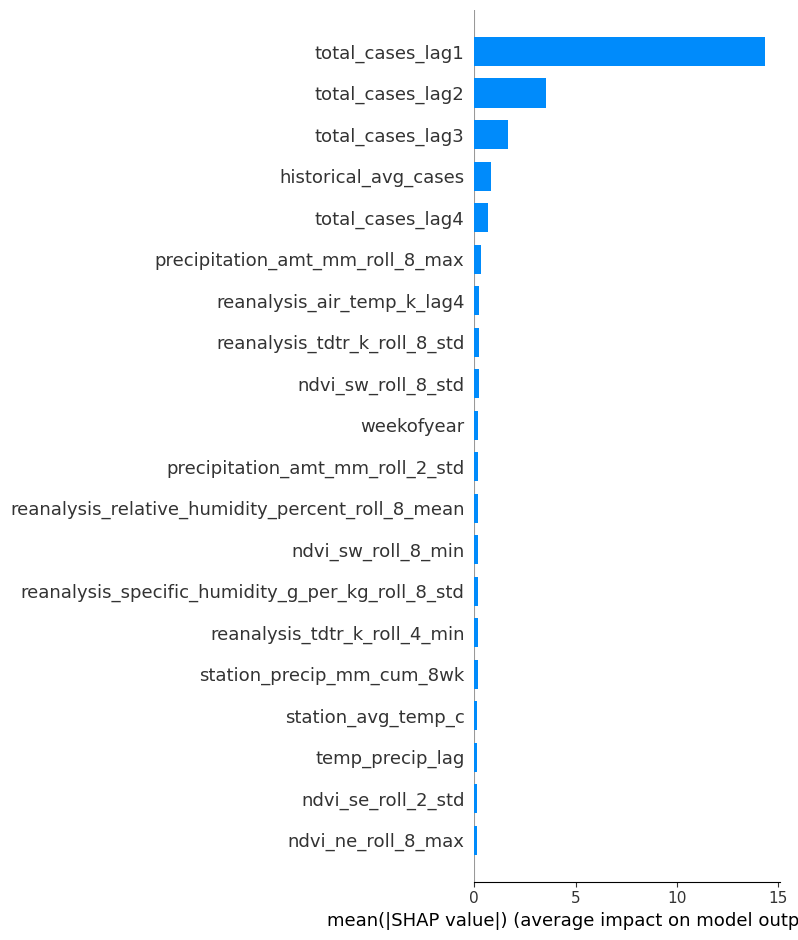

Generating SHAP summary plot (detailed)...


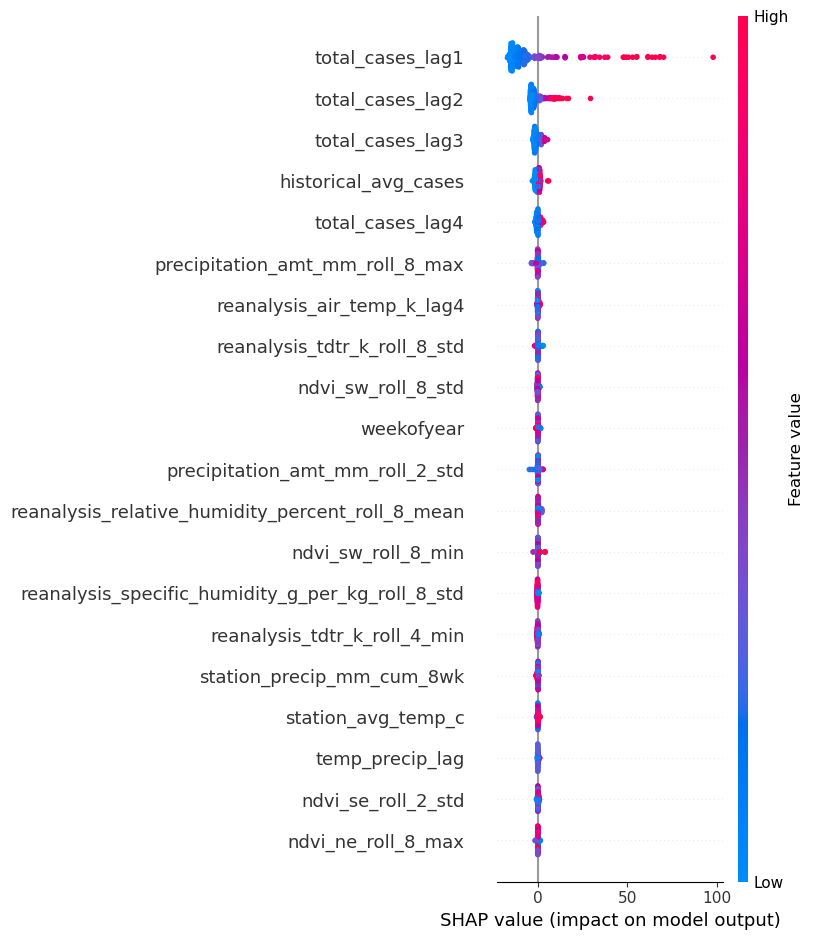

Generating SHAP dependence plots for top features...


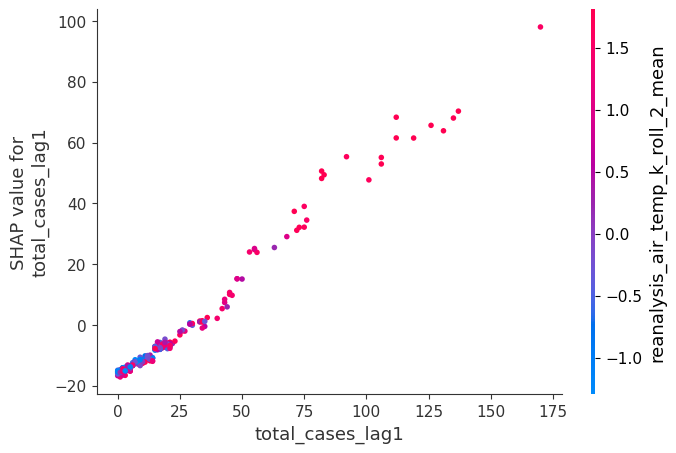

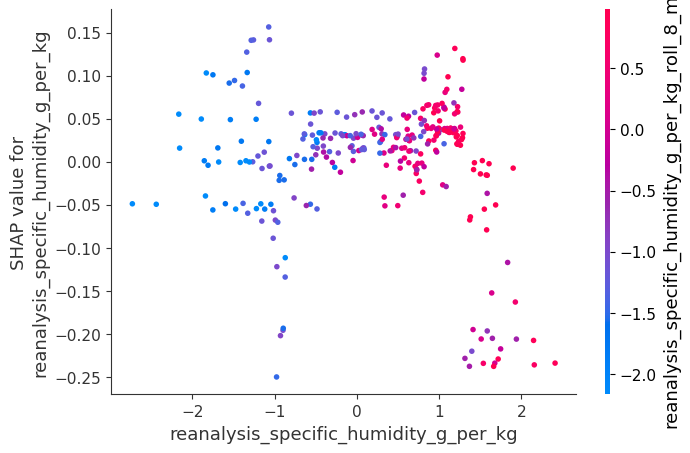

In [54]:
def create_shap_visualizations(train_df, test_df, combined_results):
    
    test_df_encoded = pd.get_dummies(test_df, columns=['city'], drop_first=False)
    
    exclude_cols = ['week_start_date', 'total_cases']
    feature_cols = [col for col in test_df_encoded.columns if col not in exclude_cols]
    
    explainer = shap.TreeExplainer(combined_results['model'])
    
    X_test = test_df_encoded[feature_cols]
    shap_values = explainer.shap_values(X_test)
    
    print("Generating SHAP summary plot (bar)...")
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    
    print("Generating SHAP summary plot (detailed)...")
    shap.summary_plot(shap_values, X_test)
    
    print("Generating SHAP dependence plots for top features...")
    shap.dependence_plot("total_cases_lag1", shap_values, X_test)
    shap.dependence_plot("reanalysis_specific_humidity_g_per_kg", shap_values, X_test)
    
    return {
        'shap_values': shap_values,
        'X_test': X_test
    }

shap_results = create_shap_visualizations(train_df, test_df, combined_results)

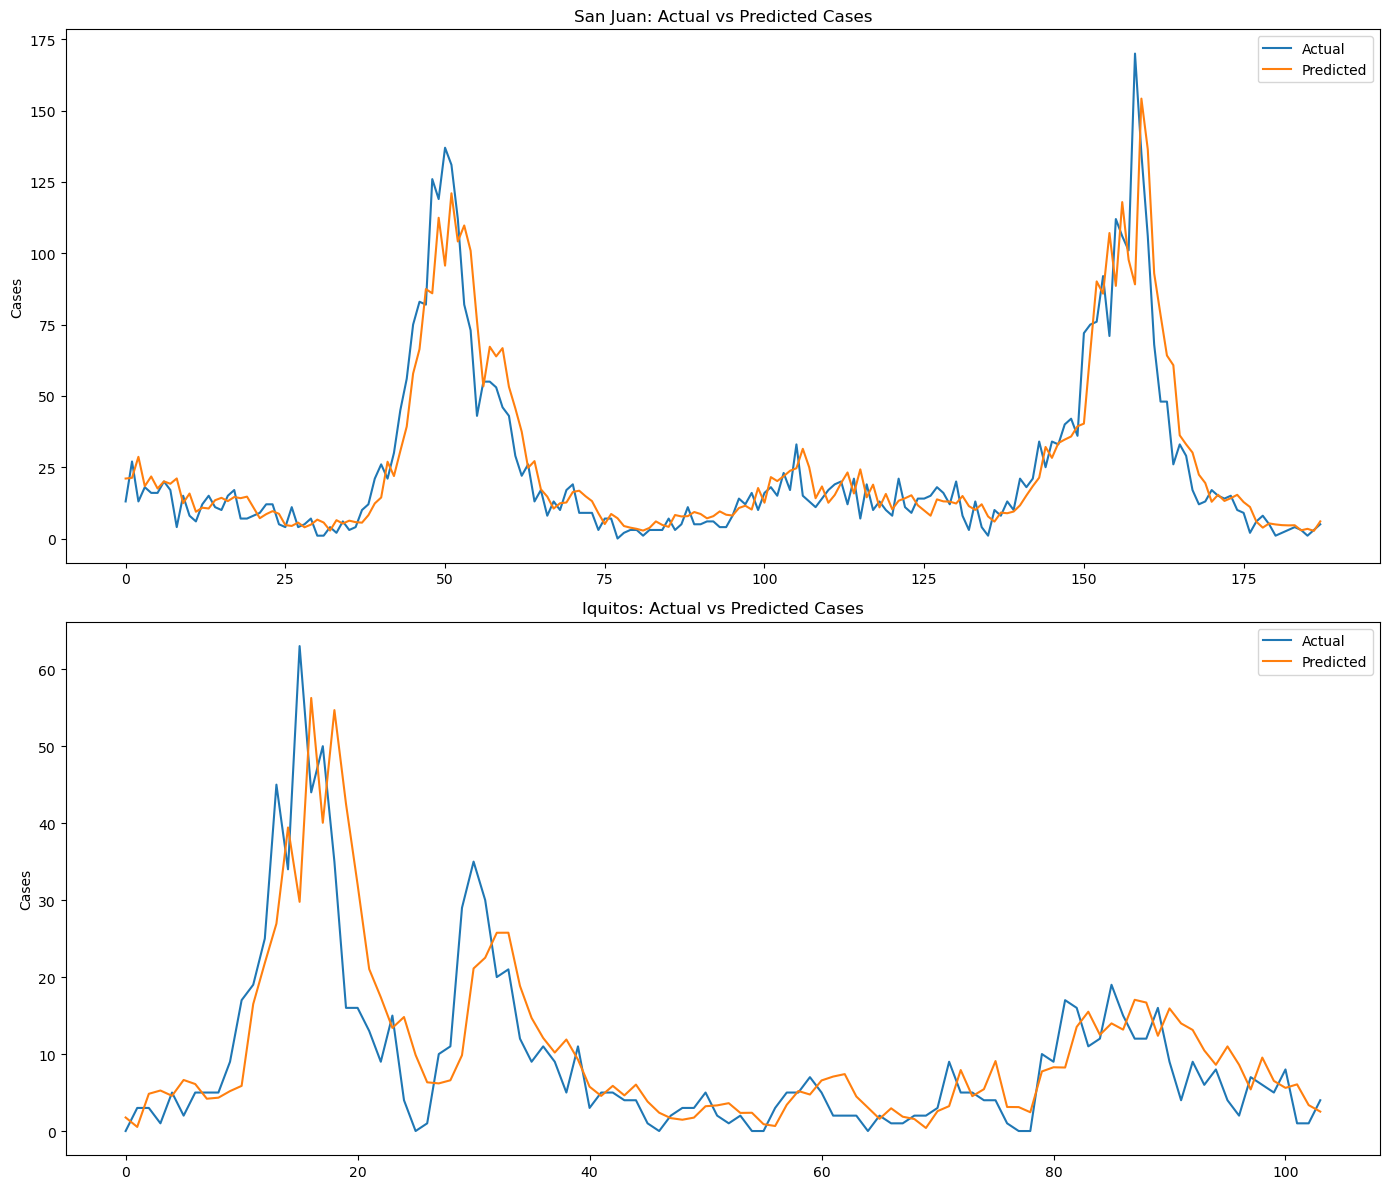

In [55]:
def plot_actual_vs_predicted(test_df, combined_results):
    """Plot actual vs predicted values by city"""
    import matplotlib.pyplot as plt
    
    test_df_encoded = pd.get_dummies(test_df, columns=['city'], drop_first=False)
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    sj_mask = test_df_encoded['city_sj'] == 1
    sj_actual = test_df.loc[sj_mask, 'total_cases'].values
    sj_pred = combined_results['y_pred'][sj_mask]
    
    axes[0].plot(sj_actual, label='Actual')
    axes[0].plot(sj_pred, label='Predicted')
    axes[0].set_title('San Juan: Actual vs Predicted Cases')
    axes[0].legend()
    axes[0].set_ylabel('Cases')
    
    iq_mask = test_df_encoded['city_iq'] == 1
    iq_actual = test_df.loc[iq_mask, 'total_cases'].values
    iq_pred = combined_results['y_pred'][iq_mask]
    
    axes[1].plot(iq_actual, label='Actual')
    axes[1].plot(iq_pred, label='Predicted')
    axes[1].set_title('Iquitos: Actual vs Predicted Cases')
    axes[1].legend()
    axes[1].set_ylabel('Cases')
    
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(test_df, combined_results)

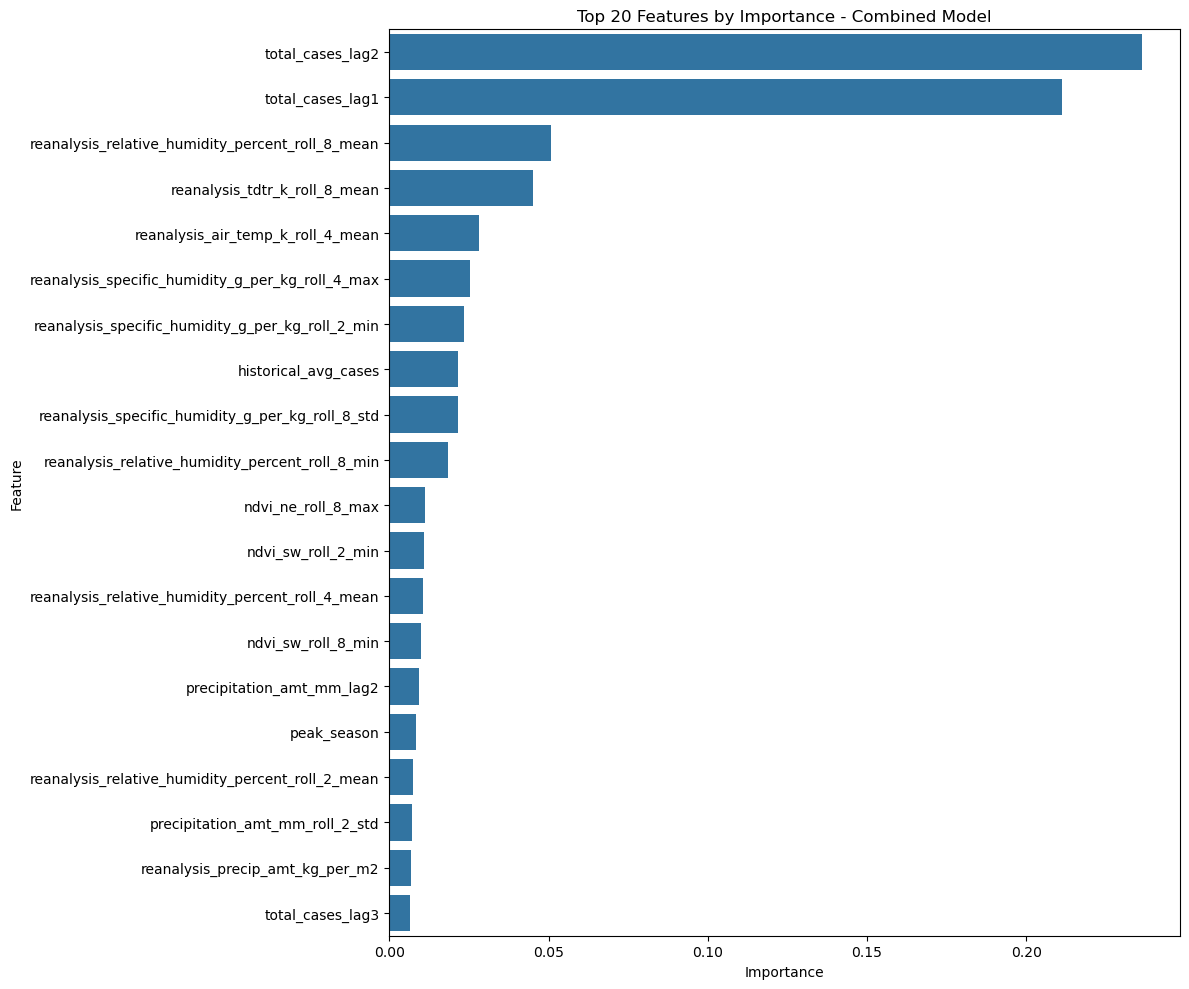

In [56]:
def plot_feature_importance(combined_results, train_df, test_df):
        
    test_df_encoded = pd.get_dummies(test_df, columns=['city'], drop_first=False)
    feature_cols = [col for col in test_df_encoded.columns 
                  if col not in ['week_start_date', 'total_cases']]
    
    importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': combined_results['model'].feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=importance.head(20))
    plt.title('Top 20 Features by Importance - Combined Model')
    plt.tight_layout()
    plt.show()
    
    return importance

importance_df = plot_feature_importance(combined_results, train_df, test_df)

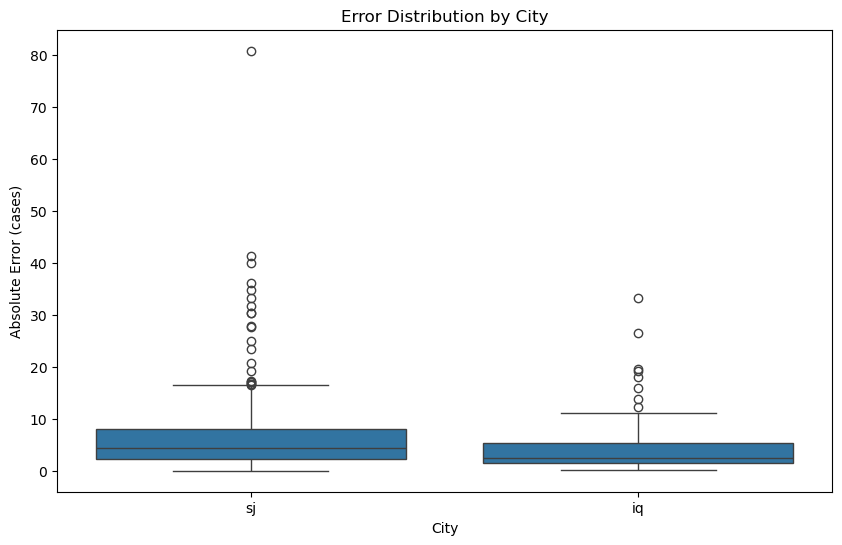

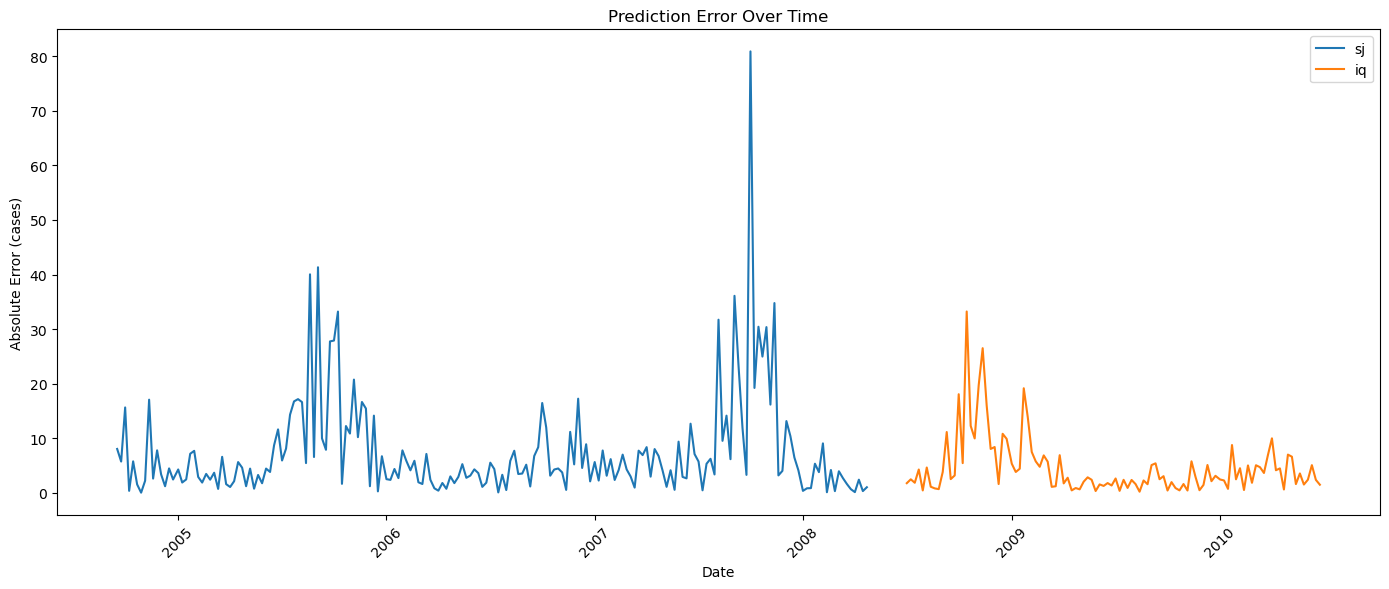

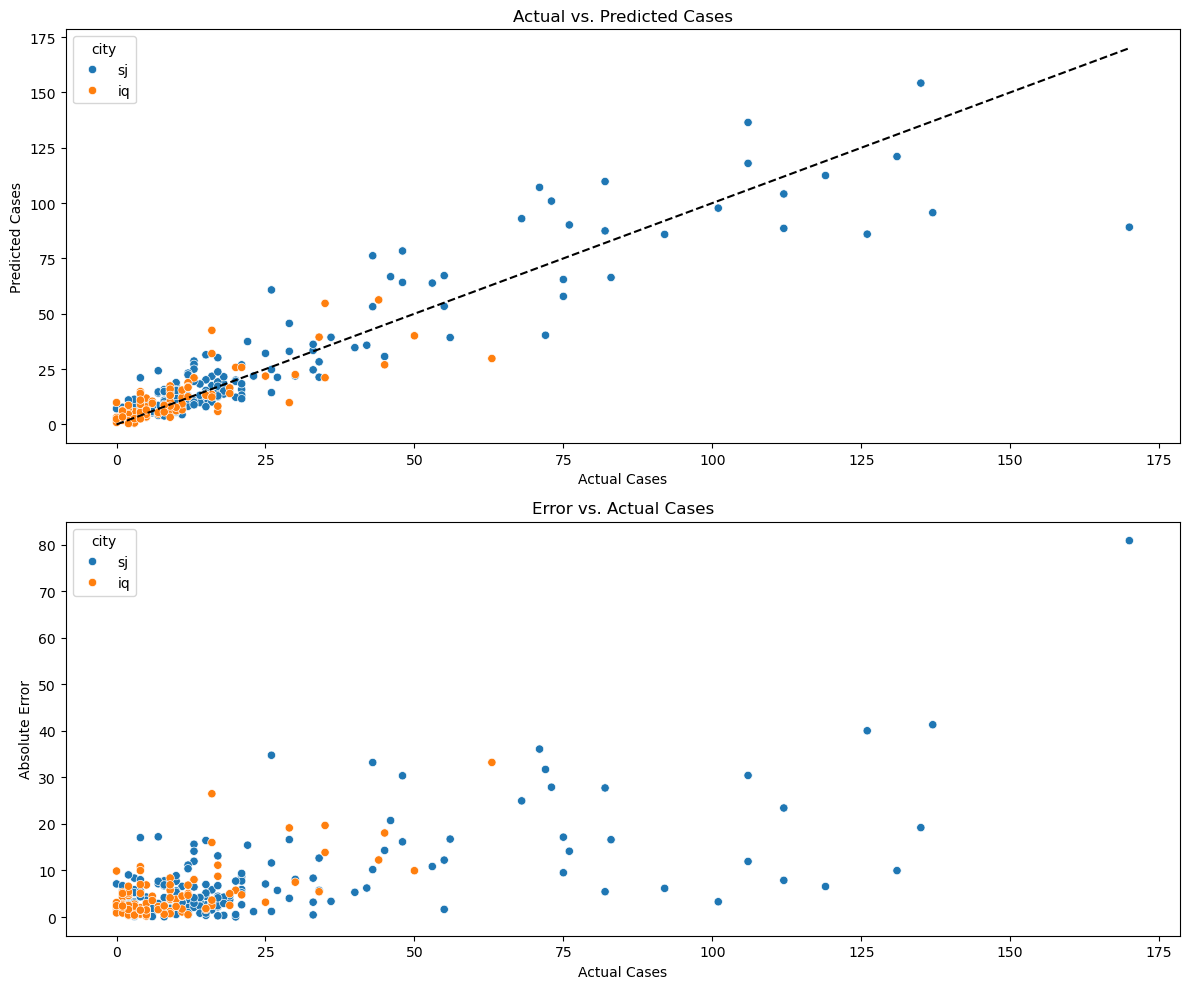

In [57]:
def plot_error_analysis(test_df, combined_results):
    """Create error analysis visualizations"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd
    
    test_df_encoded = pd.get_dummies(test_df, columns=['city'], drop_first=False)
    
    error_df = pd.DataFrame({
        'city': test_df['city'],
        'actual': combined_results['y_test'],
        'predicted': combined_results['y_pred'],
        'error': np.abs(combined_results['y_test'] - combined_results['y_pred']),
        'week_start_date': test_df['week_start_date']
    })
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='city', y='error', data=error_df)
    plt.title('Error Distribution by City')
    plt.ylabel('Absolute Error (cases)')
    plt.xlabel('City')
    plt.show()
    
    error_df['date'] = pd.to_datetime(error_df['week_start_date'])
    
    plt.figure(figsize=(14, 6))
    for city in ['sj', 'iq']:
        city_error = error_df[error_df['city'] == city]
        plt.plot(city_error['date'], city_error['error'], label=city)
    
    plt.title('Prediction Error Over Time')
    plt.xlabel('Date')
    plt.ylabel('Absolute Error (cases)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    sns.scatterplot(x='actual', y='predicted', hue='city', data=error_df)
    plt.plot([0, error_df['actual'].max()], [0, error_df['actual'].max()], 'k--')
    plt.title('Actual vs. Predicted Cases')
    plt.xlabel('Actual Cases')
    plt.ylabel('Predicted Cases')
    
    plt.subplot(2, 1, 2)
    sns.scatterplot(x='actual', y='error', hue='city', data=error_df)
    plt.title('Error vs. Actual Cases')
    plt.xlabel('Actual Cases')
    plt.ylabel('Absolute Error')
    
    plt.tight_layout()
    plt.show()
    
    return error_df

error_analysis = plot_error_analysis(test_df, combined_results)

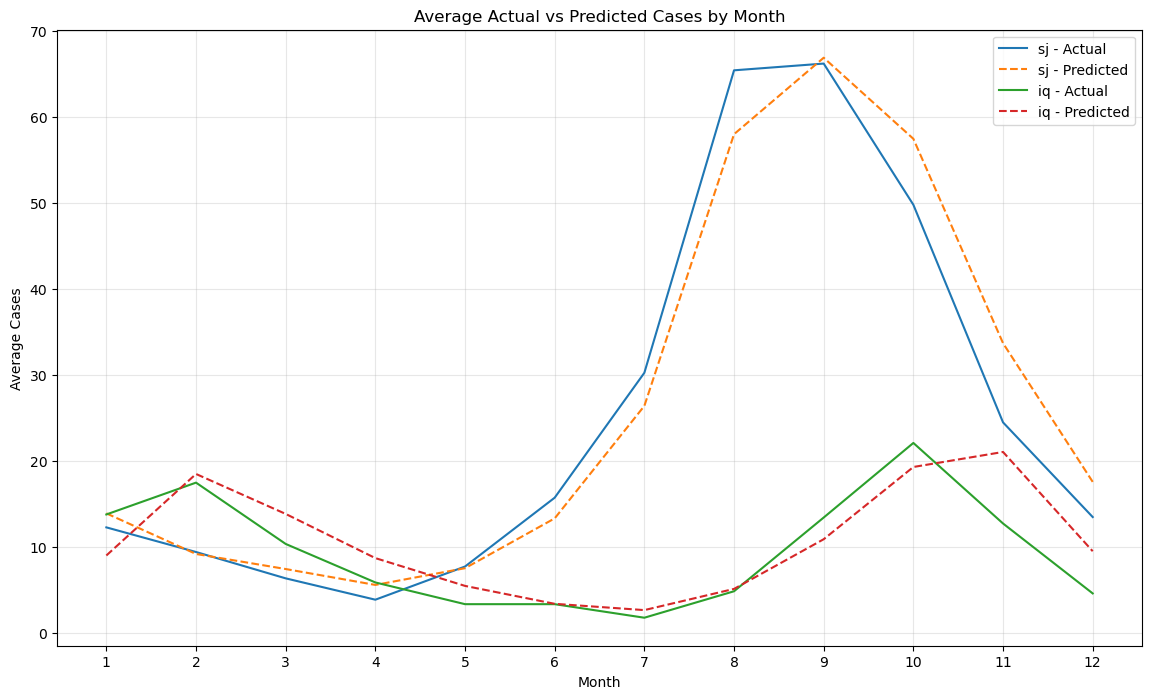

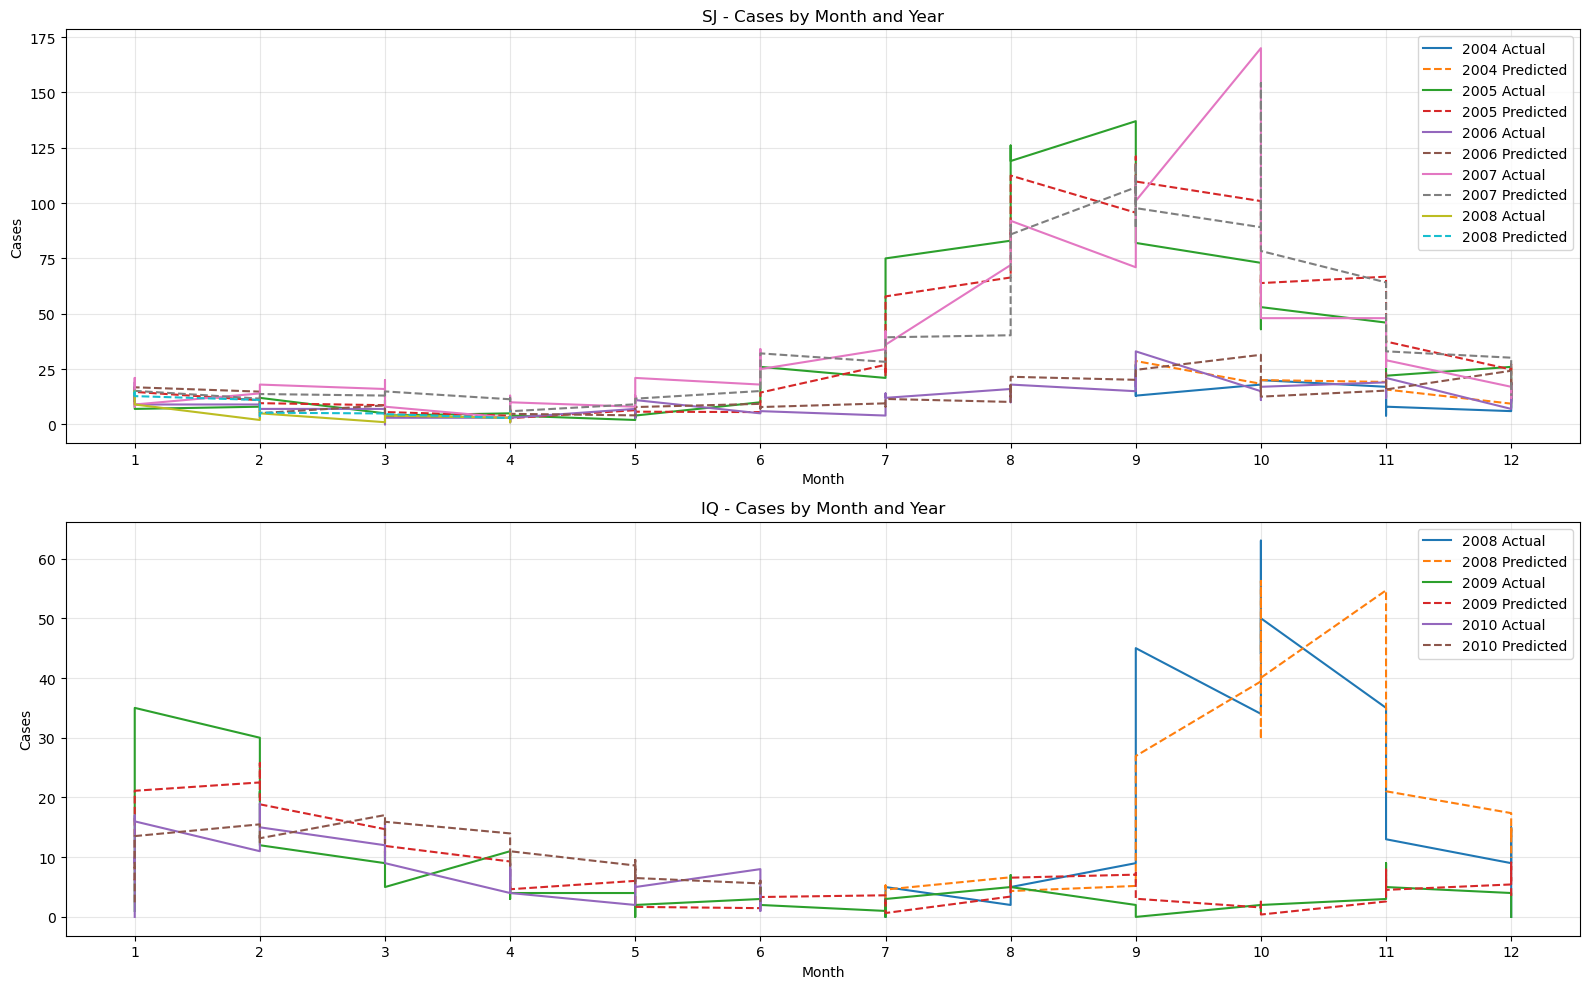

In [58]:
def plot_seasonal_patterns(test_df, combined_results):
    
    test_df_encoded = pd.get_dummies(test_df, columns=['city'], drop_first=False)
    
    test_with_date = test_df.copy()
    test_with_date['date'] = pd.to_datetime(test_with_date['week_start_date'])
    test_with_date['month'] = test_with_date['date'].dt.month
    test_with_date['year'] = test_with_date['date'].dt.year
    test_with_date['predicted'] = combined_results['y_pred']
    
    plt.figure(figsize=(14, 8))
    for city in ['sj', 'iq']:
        city_data = test_with_date[test_with_date['city'] == city]
        
        avg_by_month = city_data.groupby('month').agg({
            'total_cases': 'mean',
            'predicted': 'mean'
        }).reset_index()
        
        plt.plot(avg_by_month['month'], avg_by_month['total_cases'], 
                 label=f'{city} - Actual')
        plt.plot(avg_by_month['month'], avg_by_month['predicted'], 
                 label=f'{city} - Predicted', linestyle='--')

    plt.title('Average Actual vs Predicted Cases by Month')
    plt.xlabel('Month')
    plt.ylabel('Average Cases')
    plt.xticks(range(1, 13))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    plt.figure(figsize=(16, 10))
    
    for i, city in enumerate(['sj', 'iq']):
        plt.subplot(2, 1, i+1)
        city_data = test_with_date[test_with_date['city'] == city]
        
        for year in sorted(city_data['year'].unique()):
            year_data = city_data[city_data['year'] == year]
            if len(year_data) > 0: 
                plt.plot(year_data['month'], year_data['total_cases'], 
                         label=f'{year} Actual')
                plt.plot(year_data['month'], year_data['predicted'], 
                         linestyle='--', label=f'{year} Predicted')
        
        plt.title(f"{city.upper()} - Cases by Month and Year")
        plt.xlabel('Month')
        plt.ylabel('Cases')
        plt.xticks(range(1, 13))
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return test_with_date

seasonal_data = plot_seasonal_patterns(test_df, combined_results)

In [68]:
xgb_predictions = pd.DataFrame({
    'city': test_df['city'],
    'week_start_date': test_df['week_start_date'],
    'total_cases': test_df['total_cases'], 
    'xgb_predicted': combined_results['y_pred']
})
xgb_predictions.to_csv('xgb_predictions.csv', index=False)